In [1]:
#In this notebook we will run the experiments with the pytorch-forecasting library

import os
import warnings

warnings.filterwarnings("ignore")

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import torch

import pytorch_forecasting
from pytorch_forecasting import Baseline, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder, TorchNormalizer, EncoderNormalizer
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, MultivariateNormalDistributionLoss, NormalDistributionLoss, RMSE
import numpy as np

from importlib import reload



In [2]:
#generate ar_data
ar_data = generate_ar_data(seasonality=20.0, timesteps=5000, n_series=1, seed=42)
ar_data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(ar_data.time_idx, "D")
ar_data = ar_data.astype(dict(series=str))

###############################
#Download the VIX index from yahoo finance
import yfinance as yf

vix = yf.download("^VIX")

#Compute the returns of the VIX index
vix['Adj Close'] = vix['Adj Close'].diff()
vix = vix.dropna()


#Construct Pandas dataframe with the VIX index, the Date, a time index starting from 0 and a series column to identify the series

vix = vix.reset_index()
vix['time_idx'] = vix.index
vix['series'] = 0
#Change column name
vix = vix.rename(columns={'Adj Close':'value', 'Date':'date'})
#Drop columns
vix = vix.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'])


#####################################
#ECL data

#load the data
ecl_data = pd.read_csv(".\datasets\ECL.txt", sep = ";")

#Transform the first column into a datetime object
ecl_data["date"] = pd.to_datetime(ecl_data.iloc[:,0])

#Drop first column and Select the columns Date and MT_001
ecl_data = ecl_data.drop(ecl_data.columns[0], axis = 1)[['date', 'MT_001']]

#Change the commas to dots, transfrom to numeric and fill NaN with 0 in the column MT_001
ecl_data['value'] = ecl_data['MT_001'].str.replace(',','.').astype(float).fillna(0)

#Drop all the data before the first non-zero value of the column MT_001_new
ecl_data = ecl_data.drop(ecl_data.index[0: ecl_data['value'].ne(0).idxmax()])[0:10000]

ecl_data.reset_index(drop = True, inplace = True)
ecl_data['time_idx'] = ecl_data.index
ecl_data['series'] = 0
ecl_data.drop(['MT_001'], axis = 1, inplace = True)


[*********************100%%**********************]  1 of 1 completed


FileNotFoundError: [Errno 2] No such file or directory: '.\\datasets\\ECL.txt'

#### DATA SELECTION AND DATALOADER BUILDING

In [26]:
# Import custom normalization modules
import normalizers.GAS_norm
from normalizers.GAS_norm import SD_Normalization_Student
from importlib import reload
reload(normalizers.GAS_norm)
import numpy as np

import models.RecurrentNetwork_mod
reload(models.RecurrentNetwork_mod)
from models.RecurrentNetwork_mod import RecurrentNetwork_mod

def prepare_dataset(data, use_gas_normalization, gas_norm_strength=None, degrees_freedom=None):
    # Define cutoffs for training, validation, and test sets (10% validation, 20% test)
    total_length = len(data)
    validation_cutoff = int(total_length * 0.7)
    test_cutoff = int(total_length * 0.8)

    if use_gas_normalization:
        # Perform GAS normalization
        mu_list, sigma2_list, y_norm, alpha_mu, alpha_sigma, beta_mu, beta_sigma, omega_mu, omega_sigma, nu = SD_Normalization_Student(
            data['value'], data['value'][:validation_cutoff], mode='predict',
            norm_strength=gas_norm_strength, degrees_freedom=degrees_freedom
        )
        data['mu'] = mu_list
        data['sigma2'] = sigma2_list
        target_normalizer = TorchNormalizer(method='identity', center=False)

        
        #Add norm_strength to gas_params
        gas_params = alpha_mu, alpha_sigma, beta_mu, beta_sigma, omega_mu, omega_sigma, nu, norm_strength

        # Plot the normalized data
        plt.plot(data['time_idx'][1:], y_norm[1:])
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.title('Normalized data')
        plt.show()

        # Plot the original data with the predicted mean and 95% variability interval
        plt.plot(data['time_idx'], data['value'], label='Original data')
        plt.plot(data['time_idx'], mu_list, label='Predicted mean')
        plt.fill_between(data['time_idx'], mu_list-1.96*np.sqrt(sigma2_list), mu_list+1.96*np.sqrt(sigma2_list), alpha=0.5, label='95% variability interval', color='orange')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.title('Original data with predicted mean and 95% variability interval')
        plt.legend()
        plt.show()

    else:
        # Use other normalization method
        gas_params = []
        target_normalizer = normalizer_choice

        # Plot original data
        plt.plot(data['time_idx'], data['value'], label='Original data')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.title('Original data')
        plt.legend()
        plt.show()

    # Create datasets and dataloaders
    training = TimeSeriesDataSet(
        data[lambda x: x.time_idx <= validation_cutoff],
        time_idx="time_idx",
        target="value",
        group_ids=["series"],
        time_varying_unknown_reals=["value"],
        time_varying_known_reals=['mu', 'sigma2'] if use_gas_normalization else [],
        scalers={'mu': None, 'sigma2': None} if use_gas_normalization else {},
        max_encoder_length=max_encoder_length,
        max_prediction_length=max_prediction_length,
        target_normalizer=target_normalizer
    )
    
    validation = TimeSeriesDataSet.from_dataset(training, data[lambda x: x.time_idx <= test_cutoff], min_prediction_idx=validation_cutoff + 1)
    test = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=test_cutoff + 1)

    
    return training, validation, test, gas_params


# Parameters
max_encoder_length = 25
max_prediction_length = 50
batch_size = 128
mean_norm_strength = 0.001
var_norm_strength = 0.001
degrees_freedom = 20
norm_strength = [mean_norm_strength, var_norm_strength]

# Generate data
data_name = 'AR'
if data_name == 'AR':
    data = ar_data.copy()
elif data_name == 'VIX':
    data = vix.copy()
elif data_name == 'ECL':
    data = ecl_data.copy()

# Choose normalization type
use_gas_normalization = False  # Set to False to use other normalization methods
use_batch_norm = False  # Set to False to use other normalization methods
use_revin = False  # Set to True to use the revin method
normalizer_choice = EncoderNormalizer()

if use_batch_norm or use_revin:
    normalizer_choice = TorchNormalizer(method = 'identity', center = False)


#### Model Initialization and Hyperparams selction

Seed set to 42


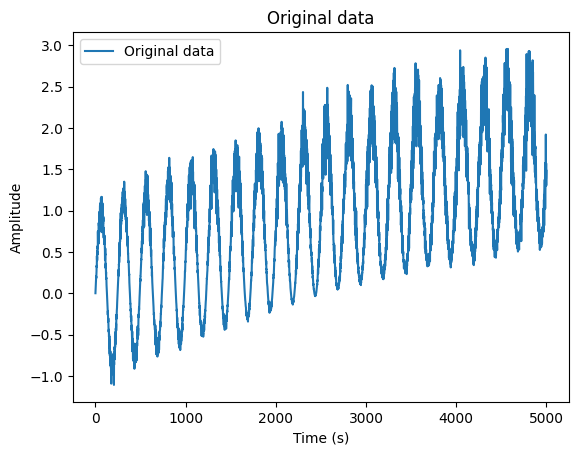

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Finding best initial lr: 100%|██████████| 100/100 [00:27<00:00,  3.70it/s]
Learning rate set to 0.008912509381337452
Restoring states from the checkpoint path at c:\Users\euret\OneDrive\Documenti\PhD\Experiments\GAS_Norm\.lr_find_b62e2b56-ab0e-46a6-b4a3-f9bbc5c1f584.ckpt
Restored all states from the checkpoint at c:\Users\euret\OneDrive\Documenti\PhD\Experiments\GAS_Norm\.lr_find_b62e2b56-ab0e-46a6-b4a3-f9bbc5c1f584.ckpt


suggested learning rate: 0.008912509381337452


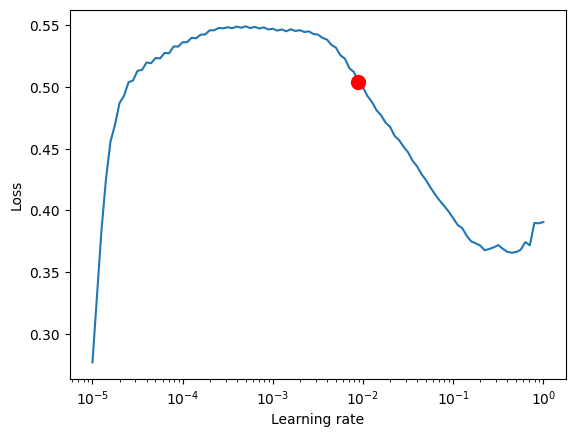

Best learning rate:  0.008912509381337452
Best norm_strength:  None


In [29]:
from lightning.pytorch.tuner import Tuner

from importlib import reload
import models.GAS_LSTM
reload(models.GAS_LSTM)
from models.GAS_LSTM import GAS_LSTM, GAS_MAE

pl.seed_everything(42)


# Parameters for optimization
best_performance = float('inf')
best_learning_rate = None
best_norm_strength = None

# checkpointing for training
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="val_loss", filename="hyper_optim", mode="min", save_top_k=1
)

if use_gas_normalization:
    # Define a range for norm_strength
    norm_strength_values = [0.001, 0.01, 0.1, 0.5]  # Example values

    for norm_strength_value in norm_strength_values:
        # Prepare dataset and dataloaders with GAS normalization
        norm_strength = [norm_strength_value, norm_strength_value]
        training, validation, test, gas_params = prepare_dataset(
            data, use_gas_normalization=use_gas_normalization, gas_norm_strength=norm_strength, degrees_freedom=degrees_freedom
        )

        
        train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0, shuffle=False)
        val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0, shuffle=False)
        test_dataloader = test.to_dataloader(train=False, batch_size=batch_size, num_workers=0, shuffle=False)

        # Initialize the model for each norm_strength
        trainer = pl.Trainer(accelerator="cpu")
        net = GAS_LSTM.from_dataset(
            training,
            cell_type="LSTM",   
            learning_rate=1e-2,
            hidden_size=30,
            rnn_layers=2,
            loss=GAS_MAE(),
            optimizer="Adam",
            gas_params= gas_params,
            )

        # Find optimal learning rate
        res = Tuner(trainer).lr_find(
            net,
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader,
            min_lr=1e-5,
            max_lr=1e0,
            early_stop_threshold=100,
        )
        learning_rate = res.suggestion()
        print(f"suggested learning rate: {res.suggestion()}")
        fig = res.plot(show=True, suggest=True)
        fig.show()

        # Update the learning rate in model
        net.hparams.learning_rate = learning_rate

        # Full training cycle
        trainer = pl.Trainer(
            max_epochs=3,
            accelerator="cpu",
            callbacks=[checkpoint_callback],
            enable_checkpointing=True,
        )
        trainer.fit(net, train_dataloader, val_dataloader)

        # Evaluate model performance
        current_performance = trainer.test(net, val_dataloader)[0]['test_loss']

        # Update best parameters if current model is better
        if current_performance < best_performance:
            best_performance = current_performance
            best_norm_strength = norm_strength
            best_learning_rate = learning_rate

else:
    # Prepare dataset and dataloaders without GAS normalization
    training, validation, test, _ = prepare_dataset(
            data, use_gas_normalization=use_gas_normalization, gas_norm_strength=norm_strength, degrees_freedom=degrees_freedom
        )
    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0, shuffle=False)
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0, shuffle=False)
    test_dataloader = test.to_dataloader(train=False, batch_size=batch_size, num_workers=0, shuffle=False)

    # Initialize the model for each norm_strength
    trainer = pl.Trainer(accelerator="cpu")
    
    net = RecurrentNetwork_mod.from_dataset(
        training,
        cell_type="LSTM",   
        learning_rate=1e-2,
        hidden_size=30,
        rnn_layers=2,
        loss=MAE(),
        optimizer="Adam",
        use_batch_norm=use_batch_norm,
        use_revin=use_revin
        )
    
        # Find optimal learning rate
    res = Tuner(trainer).lr_find(
            net,
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader,
            min_lr=1e-5,
            max_lr=1e0,
        )
    print(f"suggested learning rate: {res.suggestion()}")
    fig = res.plot(show=True, suggest=True)
    fig.show()

    # Update the learning rate
    best_learning_rate = res.suggestion()
    
    

#Print results
print('Best learning rate: ', best_learning_rate)
print('Best norm_strength: ', best_norm_strength)



#### TRAIN AND TEST THE MODEL

In [5]:

# If use GAS normalization, we need to build the datalosader again with the best norm_strength
if use_gas_normalization:
    training, validation, test, gas_params = prepare_dataset(
        data, use_gas_normalization=use_gas_normalization, gas_norm_strength=best_norm_strength, degrees_freedom=degrees_freedom
    )

    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0, shuffle=False)
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0, shuffle=False)
    test_dataloader = test.to_dataloader(train=False, batch_size=batch_size, num_workers=0, shuffle=False)
    

#We now repeat the training and test process 5 times to get a better estimate of the performance
#At the end of each training, we save the model with the best performance on the validation set
#The best model is then tested on the test set and the performance is saved for later analysis
trials = 5
results = np.zeros(trials)

for trial in range(trials):

    pl.seed_everything(trial)

    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        monitor="val_loss",
        dirpath=f"trials_{data_name}_diff_{use_gas_normalization}_enc_norm={max_encoder_length}_dec={max_prediction_length}/",
        filename=f"best_model_{trial}",  # include the trial number in the filename
        mode="min", 
        save_top_k=1
    )

    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=3, verbose=False, mode="min")

    trainer = pl.Trainer(
    max_epochs=10,
    accelerator="cpu",
    enable_model_summary=True,
    callbacks=[early_stop_callback, checkpoint_callback],
    enable_checkpointing=True,
    )
    #Init model
    if use_gas_normalization:
         
        net = GAS_LSTM.from_dataset(
            training,
            cell_type="LSTM",
            learning_rate=best_learning_rate,
            log_interval=1,
            log_val_interval=1,
            hidden_size=30,
            rnn_layers=2,
            optimizer="Adam",
            loss=GAS_MAE(), 
            gas_params= gas_params,
        )

    else:
        
        net = RecurrentNetwork_mod.from_dataset(
            training,
            cell_type="LSTM",
            learning_rate=best_learning_rate,
            log_interval=1,
            log_val_interval=1,
            hidden_size=30,
            rnn_layers=2,
            optimizer="Adam",
            loss=MAE(), 
            use_batch_norm=use_batch_norm,
            use_revin=use_revin
            )


    trainer.fit(
        net,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )

    if use_gas_normalization:
        #Load best model
        net = GAS_LSTM.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
        print(f"Best model on validation set: {trainer.checkpoint_callback.best_model_path}")
    else:
        #Load best model
        net = RecurrentNetwork_mod.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
        print(f"Best model on validation set: {trainer.checkpoint_callback.best_model_path}")
        

    #Test model
    result = trainer.test(
        net,
        test_dataloader,
        verbose=True,
    )

    #Save results
    results[trial] = result[0]['test_loss']

#Print results
print('Results: ', results)

Seed set to 0
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type           | Params
----------------------------------------------------
0 | loss             | MAE            | 0     
1 | logging_metrics  | ModuleList     | 0     
2 | embeddings       | MultiEmbedding | 0     
3 | rnn              | LSTM           | 11.4 K
4 | output_projector | Linear         | 31    
5 | encoder_bn       | BatchNorm1d    | 2     
6 | decoder_bn       | BatchNorm1d    | 2     
7 | revin_layer      | RevIN          | 2     
----------------------------------------------------
11.4 K    Trainable params
0         Non-trainable params
11.4 K    Total params
0.046     Total estimated model params size (MB)


Epoch 5: 100%|██████████| 54/54 [00:14<00:00,  3.66it/s, v_num=109, train_loss_step=5.210, val_loss=5.660, train_loss_epoch=4.400]
Best model on validation set: trials_ECL_diff_False_enc_norm=25_dec=50/best_model_0.ckpt
Testing DataLoader 0: 100%|██████████| 16/16 [00:04<00:00,  3.54it/s]

Seed set to 1
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type           | Params
----------------------------------------------------
0 | loss             | MAE            | 0     
1 | logging_metrics  | ModuleList     | 0     
2 | embeddings       | MultiEmbedding | 0     
3 | rnn              | LSTM           | 11.4 K
4 | output_projector | Linear         | 31    
5 | encoder_bn       | BatchNorm1d    | 2     
6 | decoder_bn       | BatchNorm1d    | 2     
7 | revin_layer      | RevIN          | 2     
----------------------------------------------------
11.4 K    Trainable params
0         Non-trainable params
11.4 K    Total params
0.046     Total estimated model params size (MB)



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_MAE             5.148705959320068
        test_MAPE           0.8881928324699402
        test_MASE            2.105553388595581
        test_RMSE            6.935790538787842
       test_SMAPE           0.5294741988182068
        test_loss            5.148705959320068
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 3: 100%|██████████| 54/54 [00:15<00:00,  3.51it/s, v_num=110, train_loss_step=5.650, val_loss=5.470, train_loss_epoch=4.870]
Best model on validation set: trials_ECL_diff_False_enc_norm=25_dec=50/best_model_1.ckpt
Testing DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.00it/s]


Seed set to 2
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type           | Params
----------------------------------------------------
0 | loss             | MAE            | 0     
1 | logging_metrics  | ModuleList     | 0     
2 | embeddings       | MultiEmbedding | 0     
3 | rnn              | LSTM           | 11.4 K
4 | output_projector | Linear         | 31    
5 | encoder_bn       | BatchNorm1d    | 2     
6 | decoder_bn       | BatchNorm1d    | 2     
7 | revin_layer      | RevIN          | 2     
----------------------------------------------------
11.4 K    Trainable params
0         Non-trainable params
11.4 K    Total params
0.046     Total estimated model params size (MB)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_MAE             5.258263111114502
        test_MAPE           0.9567261338233948
        test_MASE            2.146233081817627
        test_RMSE            7.056851863861084
       test_SMAPE            0.538600742816925
        test_loss            5.258263111114502
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 5: 100%|██████████| 54/54 [00:16<00:00,  3.23it/s, v_num=111, train_loss_step=5.390, val_loss=5.920, train_loss_epoch=4.560]
Best model on validation set: trials_ECL_diff_False_enc_norm=25_dec=50/best_model_2.ckpt
Testing DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.16it/s]

Seed set to 3



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_MAE             5.347665786743164
        test_MAPE           1.0155391693115234
        test_MASE            2.175999641418457
        test_RMSE            7.197132110595703
       test_SMAPE           0.5424632430076599
        test_loss            5.347665786743164
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type           | Params
----------------------------------------------------
0 | loss             | MAE            | 0     
1 | logging_metrics  | ModuleList     | 0     
2 | embeddings       | MultiEmbedding | 0     
3 | rnn              | LSTM           | 11.4 K
4 | output_projector | Linear         | 31    
5 | encoder_bn       | BatchNorm1d    | 2     
6 | decoder_bn       | BatchNorm1d    | 2     
7 | revin_layer      | RevIN          | 2     
----------------------------------------------------
11.4 K    Trainable params
0         Non-trainable params
11.4 K    Total params
0.046     Total estimated model params size (MB)


Epoch 3: 100%|██████████| 54/54 [00:16<00:00,  3.25it/s, v_num=112, train_loss_step=5.560, val_loss=5.540, train_loss_epoch=4.760]
Best model on validation set: trials_ECL_diff_False_enc_norm=25_dec=50/best_model_3.ckpt
Testing DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.03it/s]

Seed set to 4



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_MAE             5.221502304077148
        test_MAPE           0.9289841651916504
        test_MASE           2.1332004070281982
        test_RMSE            7.006436824798584
       test_SMAPE           0.5360175371170044
        test_loss            5.221502304077148
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type           | Params
----------------------------------------------------
0 | loss             | MAE            | 0     
1 | logging_metrics  | ModuleList     | 0     
2 | embeddings       | MultiEmbedding | 0     
3 | rnn              | LSTM           | 11.4 K
4 | output_projector | Linear         | 31    
5 | encoder_bn       | BatchNorm1d    | 2     
6 | decoder_bn       | BatchNorm1d    | 2     
7 | revin_layer      | RevIN          | 2     
----------------------------------------------------
11.4 K    Trainable params
0         Non-trainable params
11.4 K    Total params
0.046     Total estimated model params size (MB)


Epoch 5: 100%|██████████| 54/54 [00:18<00:00,  2.99it/s, v_num=113, train_loss_step=5.330, val_loss=5.700, train_loss_epoch=4.490]
Best model on validation set: trials_ECL_diff_False_enc_norm=25_dec=50/best_model_4.ckpt
Testing DataLoader 0: 100%|██████████| 16/16 [00:04<00:00,  3.96it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_MAE             5.13849401473999
        test_MAPE           0.8829699158668518
        test_MASE            2.102250337600708
        test_RMSE            6.925687789916992
       test_SMAPE           0.5285168886184692
        test_loss            5.13849401473999
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Results:  [5.14870596 5

In [6]:
net

RecurrentNetwork_mod(
  	"categorical_groups":                {}
  	"cell_type":                         LSTM
  	"dropout":                           0.1
  	"embedding_labels":                  {}
  	"embedding_paddings":                []
  	"embedding_sizes":                   {}
  	"hidden_size":                       30
  	"learning_rate":                     0.00019952623149688798
  	"log_gradient_flow":                 False
  	"log_interval":                      1
  	"log_val_interval":                  1
  	"logging_metrics":                   ModuleList(
  	  (0): SMAPE()
  	  (1): MAE()
  	  (2): RMSE()
  	  (3): MAPE()
  	  (4): MASE()
  	)
  	"loss":                              MAE()
  	"monotone_constaints":               {}
  	"optimizer":                         Adam
  	"optimizer_params":                  None
  	"output_size":                       1
  	"output_transformer":                EncoderNormalizer(
  		method='standard',
  		center=True,
  		max_length=None

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(5.1385)
0
216
433
649
866
1082
1299
1515
1732
1949


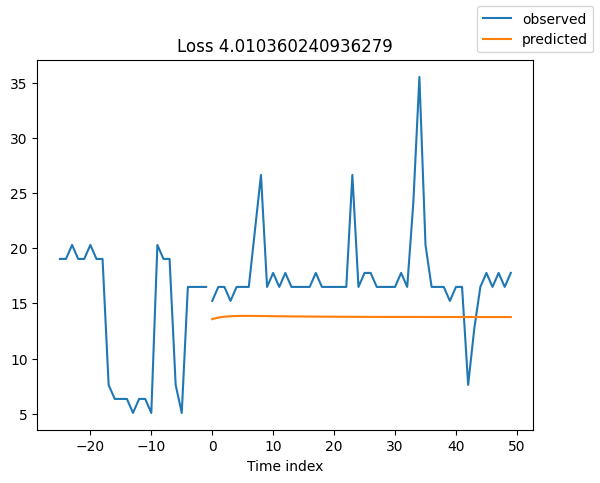

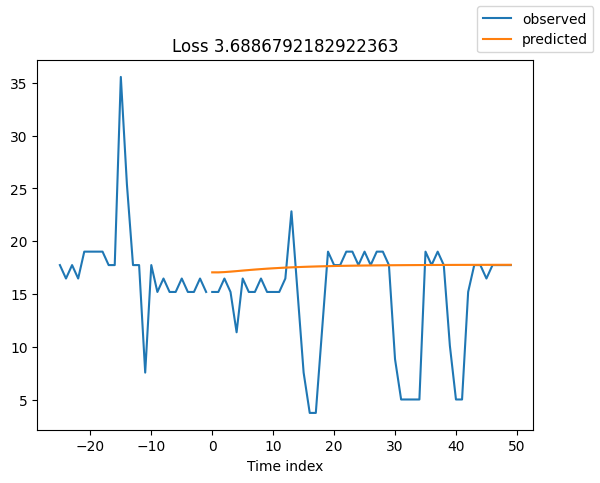

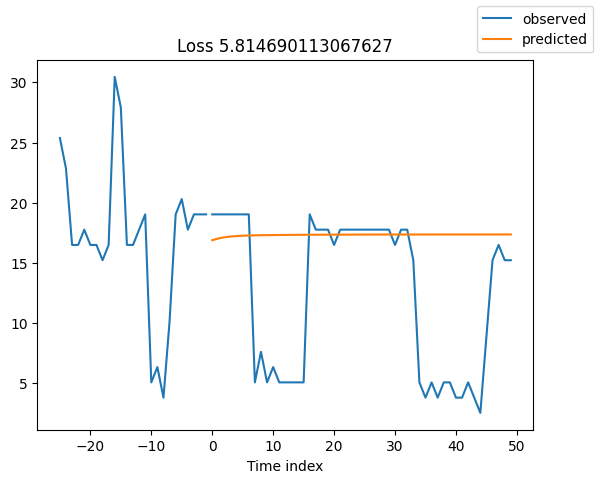

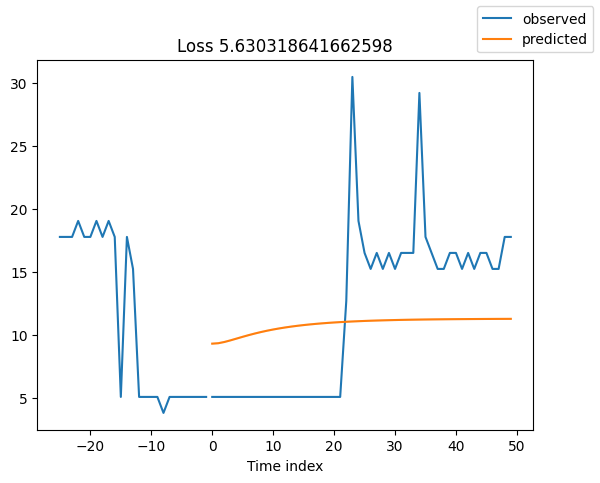

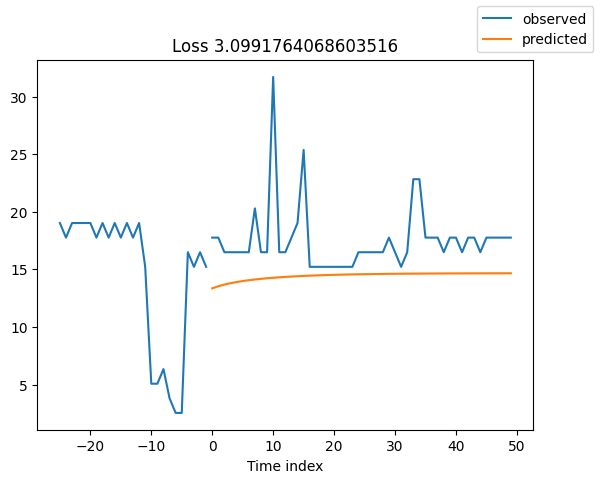

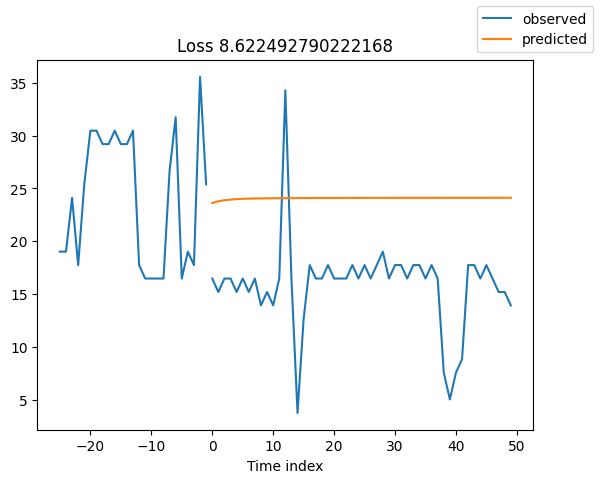

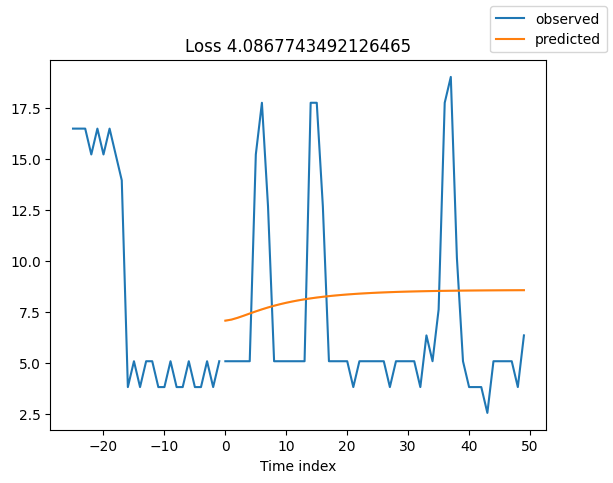

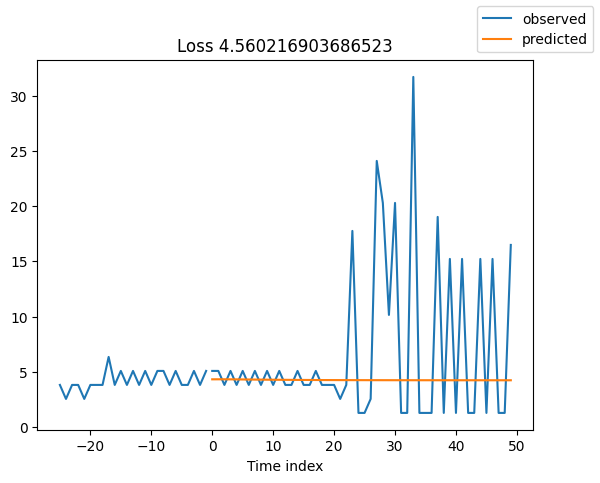

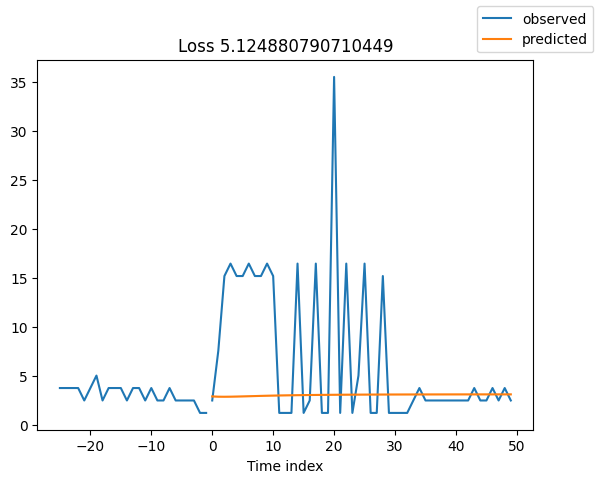

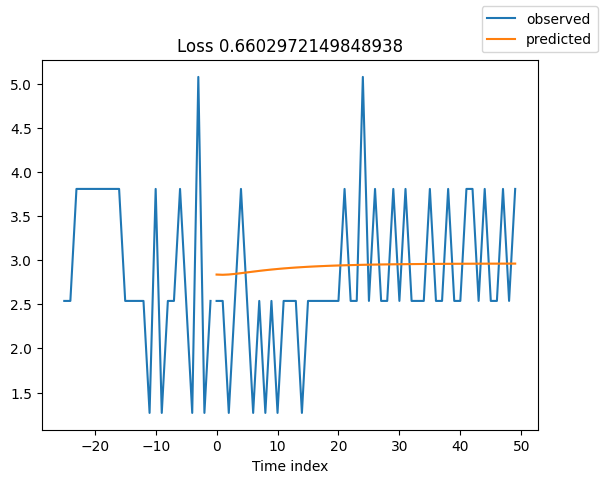

In [7]:
#Test the model on the test set

predictions = net.predict(test_dataloader, trainer_kwargs=dict(accelerator="cpu"), mode='raw', return_index=True, return_x=True)

print(MAE()(predictions.x['decoder_target'], predictions.output[0].squeeze(2)))

for i in np.linspace(0, predictions.x['encoder_target'].shape[0]-1, 10, dtype=int):
    print(i)
    net.plot_prediction(predictions.x, predictions.output, idx=i, add_loss_to_title=True)